<a href="https://colab.research.google.com/github/sujitpatel22/GANs_Projects/blob/main/Conv-Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Resize images to 32x32 using OpenCV
x_train = np.array([cv2.resize(img, (32, 32)) for img in x_train])
x_test = np.array([cv2.resize(img, (32, 32)) for img in x_test])

# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add a channel dimension (required for convolutional layers)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Print dataset shapes
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 32, 32, 1)
Test data shape: (10000, 32, 32, 1)


In [4]:
def add_noise(images, noise_factor=0.4):
    # Generate Gaussian noise
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)

    # Add the noise to the images
    noisy_images = images + noise

    # Clip the images to be in the range [0, 1]
    noisy_images = np.clip(noisy_images, 0, 1)

    return noisy_images

# Apply noise to the training and test images
noise_factor = 0.3  # Define how much noise to add
x_train_noisy = add_noise(x_train, noise_factor=noise_factor)
x_test_noisy = add_noise(x_test, noise_factor=noise_factor)

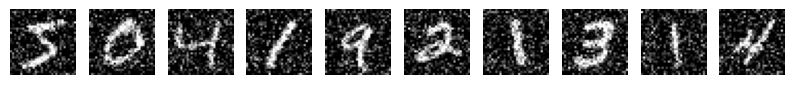

In [5]:
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train_noisy[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
plt.show()

In [6]:
# Encoder
def build_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Conv + BatchNorm + ReLU + Pooling (1st block)
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Conv + BatchNorm + ReLU + Pooling (2nd block)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Conv + BatchNorm + ReLU + Pooling (3rd block)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Latent Space (Final Conv Layer)
    latent = layers.Conv2D(256, (3, 3), padding='same')(x)
    latent = layers.BatchNormalization()(latent)
    latent = layers.ReLU()(latent)

    return models.Model(inputs, latent, name='encoder')

# Create the encoder model
input_shape = (32, 32, 1)  # Replace None with the correct shape of your input images
encoder = build_encoder(input_shape)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 4, 4, 256)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389,760 (1.49 MB)

 Trainable params: 388,800 (1.48 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
# Decoder
def build_decoder(latent_shape):
    latent_inputs = layers.Input(shape=latent_shape)

    # Upsampling + Conv + BatchNorm + ReLU (1st block)
    x = layers.Conv2DTranspose(128, (3, 3), padding='same')(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Upsampling + Conv + BatchNorm + ReLU (2nd block)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Upsampling + Conv + BatchNorm + ReLU (3rd block)
    x = layers.Conv2DTranspose(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Final Conv Layer + Sigmoid/Softmax
    outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(latent_inputs, outputs, name='decoder')

# Create the decoder model
latent_shape = encoder.output_shape[1:]  # Replace None with the correct shape of your latent representation
decoder = build_decoder(latent_shape)
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 388,481 (1.48 MB)

 Trainable params: 388,033 (1.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Autoencoder
autoencoder_input = layers.Input(shape=input_shape)
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = models.Model(autoencoder_input, decoded, name='autoencoder')

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 4, 4, 256)           │         389,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 32, 32, 1)           │         388,481 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 778,241 (2.97 MB)

 Trainable params: 776,833 (2.96 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [9]:
# Compile the autoencoder
autoencoder.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.002), loss='mse')

In [10]:
# Train the autoencoder
EPOCHS = 20
BATCH_SIZE = 128

history = autoencoder.fit(
    x_train_noisy, x_train,  # Input and target are the same
    epochs=EPOCHS,       # Replace None with the number of epochs, e.g., 50
    batch_size=BATCH_SIZE,   # Replace None with the desired batch size, e.g., 128
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - loss: 0.0220 - val_loss: 0.0091
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━

ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

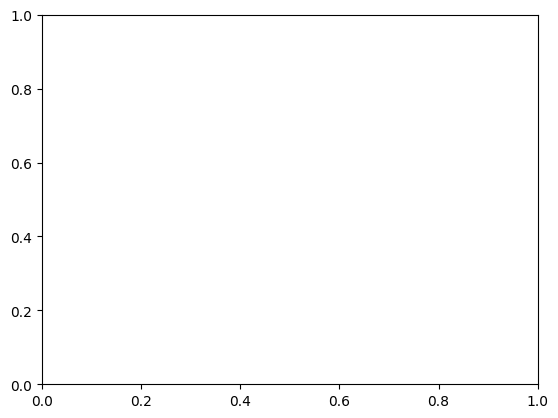

In [11]:
# Plot the training and validation loss (optional)
import matplotlib.pyplot as plt

plt.plot(EPOCHS, history.history['loss'], label='Training Loss')
plt.plot(EPOCHS, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


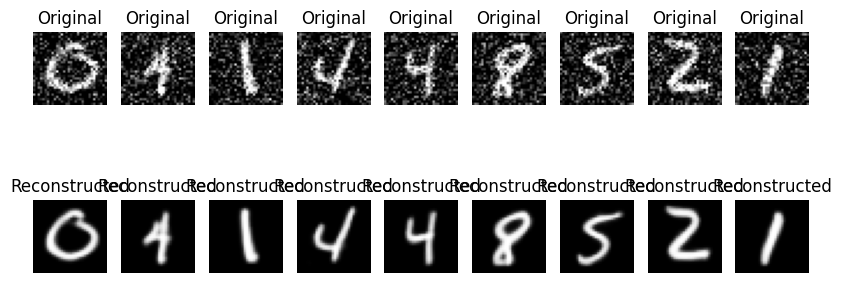

In [12]:
# Select a few test images to visualize the reconstruction
num_images = 9  # Number of images to visualize
random_indices = np.random.randint(0, len(x_test), num_images)
sample_images = x_test_noisy[random_indices]

# Use the autoencoder to reconstruct the selected images
reconstructed_images = autoencoder.predict(sample_images)

# Plot the original and reconstructed images side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(num_images):
    # Original images
    plt.subplot(2, num_images, i + 1)
    plt.imshow(sample_images[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
    plt.title('Original')

    # Reconstructed images
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed_images[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
    plt.title('Reconstructed')

plt.show()